In [2]:
from process import * 
from utils import * 
from solver import *
import torch 
from torch import distributions as pyd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
import importlib
modules = ["process", "maxent", "optimizer", "utils"]
def load_modules(modules): 
    for module in modules:
        imported_module = importlib.import_module(module)
        importlib.reload(imported_module)


load_modules(modules)

In [289]:
states = 25
n_actions = 6

In [290]:
trajectories = read_json("data/trajectories_25.json")

In [300]:
trajectories = {key: value for key, value in trajectories.items() if len(value) > 30 }

9883

In [301]:
T = convert_traj(trajectories)

p_transition = calc_tran_model(T, states, n_actions)
terminal_states = calc_terminal_states(trajectories)

reward, _ = train_single_intent(T, p_transition, states, terminal_states)

reward = np.tile(reward.reshape(-1, 1), n_actions)

mu = calc_start_dist(list(trajectories.values()), states)

np.savez(f"mdp/mdp_{states}", states=states, n_actions=n_actions, p_transition=p_transition, reward=reward, terminal_states=terminal_states, mu=mu)


/Users/jaydenpersonnat/cs184-project/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [259]:
mdp_params = np.load("mdp/mdp_25.npz")

reward = mdp_params['reward']
mu = mdp_params['mu']
p_transition = mdp_params['p_transition']
states = mdp_params['states']
actions = mdp_params['n_actions']

In [261]:
def value_iteration(p, reward, mu, H=100, eps=1e-3):
    """
    Basic value-iteration algorithm to solve the given MDP.

    Args:
        p: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.
        discount: The discount (gamma) applied during value-iteration.
        eps: The threshold to be used as convergence criterion. Convergence
            is assumed if the value-function changes less than the threshold
            on all states in a single iteration.

    Returns:
        The value function as table `[state: Integer] -> value: Float`.
    """
    n_states, _, n_actions = p.shape
    v = np.zeros(n_states)

    # Setup transition probability matrices for easy use with numpy.
    #
    # This is an array of matrices, one matrix per action. Multiplying
    # state-values v(s) with one of these matrices P_a for action a represents
    # the equation
    #     P_a * [ v(s_i) ]_i^T = [ sum_k p(s_k | s_j, a) * v(s_K) ]_j^T
    p_transition = p 

    p = [np.matrix(p[:, :, a]) for a in range(n_actions)]

    delta = np.inf

    epoch = 0 

    total_rewards = [] 

    while delta > eps and epoch < H:      # iterate until convergence
        v_old = v

        # compute state-action values (note: we actually have Q[a, s] here)
        q = np.array([p[a] @ v for a in range(n_actions)])

        # compute state values
        v = reward + np.max(q, axis=0)[0]


        state = np.random.choice(a=len(mu), p=mu)

        total_reward = 0

        # rollout trajectory
        for _ in range(H): 

            policy = np.argmax(q, axis = 0).reshape(-1, )

            action = policy[state]

            transition_probabilities = p_transition[state, :, action]
            # move on to next state 
            state = np.random.choice(a=len(transition_probabilities), p=transition_probabilities)

            # add reward for that state
            total_reward += reward[state]


        # compute maximum delta
        delta = np.max(np.abs(v_old - v))

        epoch += 1 

        total_rewards.append(total_reward)
        print(f"Episode: {epoch}, Total Reward: {total_reward}")


    return v, q, np.array(total_rewards) 


In [262]:
V, Q, total_rewards = value_iteration(p_transition, reward.T[0], mu)

Episode: 1, Total Reward: 5189.436758894079
Episode: 2, Total Reward: 6038.7879867451165
Episode: 3, Total Reward: 6412.19246485534
Episode: 4, Total Reward: 6441.8881931185315
Episode: 5, Total Reward: 5796.962208006607
Episode: 6, Total Reward: 5449.379117708032
Episode: 7, Total Reward: 5481.261079474075
Episode: 8, Total Reward: 6156.639203324476
Episode: 9, Total Reward: 6001.316198669104
Episode: 10, Total Reward: 5656.215441387665
Episode: 11, Total Reward: 6505.38569457776
Episode: 12, Total Reward: 6461.09149581363
Episode: 13, Total Reward: 6049.34756753186
Episode: 14, Total Reward: 6234.7867632088755
Episode: 15, Total Reward: 6167.656939443514
Episode: 16, Total Reward: 6167.587610941878
Episode: 17, Total Reward: 5193.284737387277
Episode: 18, Total Reward: 6016.561487414724
Episode: 19, Total Reward: 6448.201986351773
Episode: 20, Total Reward: 5593.246211818015
Episode: 21, Total Reward: 5823.8440245483725
Episode: 22, Total Reward: 5911.297518401605
Episode: 23, Total 

In [263]:
def plot_reward_heatmap(reward_function):
    """
    Plots a 5x5 heatmap using seaborn given a 1D numpy array of length 25.

    Parameters:
    reward_function (numpy array): A 1D numpy array of length 25 representing the reward function.
    """
    # if reward_function.shape != (25,):
    #     raise ValueError("Reward function must be a 1D numpy array of length 25.")

    sqrt_states = int(np.sqrt(reward_function.shape))

    # Reshape the 1D array to 5x5
    reward_matrix = reward_function.reshape(sqrt_states, sqrt_states)

    # Plot using seaborn
    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(reward_matrix, annot=True, cmap="viridis", cbar=True)
    heatmap.set_xticklabels(range(sqrt_states))
    heatmap.set_yticklabels(range(sqrt_states))
    # plt.xlabel("X-axis")
    # plt.ylabel("Y-axis")
    plt.title("Single Intent Reward Function")
    plt.show()


In [264]:
reward_two = reward - np.tile(np.array([0, 4, 10, 10, 4, 4]), (states, 1))

In [265]:
reward_two

array([[38.39752001, 34.39752001, 28.39752001, 28.39752001, 34.39752001,
        34.39752001],
       [ 1.12485712, -2.87514288, -8.87514288, -8.87514288, -2.87514288,
        -2.87514288],
       [ 1.17600523, -2.82399477, -8.82399477, -8.82399477, -2.82399477,
        -2.82399477],
       [51.99249028, 47.99249028, 41.99249028, 41.99249028, 47.99249028,
        47.99249028],
       [ 1.83334091, -2.16665909, -8.16665909, -8.16665909, -2.16665909,
        -2.16665909],
       [ 1.00021872, -2.99978128, -8.99978128, -8.99978128, -2.99978128,
        -2.99978128],
       [ 1.16186023, -2.83813977, -8.83813977, -8.83813977, -2.83813977,
        -2.83813977],
       [ 3.44573696, -0.55426304, -6.55426304, -6.55426304, -0.55426304,
        -0.55426304],
       [13.14402329,  9.14402329,  3.14402329,  3.14402329,  9.14402329,
         9.14402329],
       [ 1.08879436, -2.91120564, -8.91120564, -8.91120564, -2.91120564,
        -2.91120564],
       [ 1.59807803, -2.40192197, -8.40192197, -8.

In [266]:
def plot_reward_heatmap(reward_matrix):
    """
    Plots a heatmap for the given reward matrix.

    Args:
    reward_matrix (2D numpy array): An SxA matrix representing the reward function r(s, a),
                                    where S is the number of states and A is the number of actions.
    """

    plt.figure(figsize=(6, 24))

    # Create the heatmap using Seaborn
    ax =  sns.heatmap(reward_matrix, annot=True, cmap="viridis", cbar=False)
    
    # Add labels for clarity
    ax.set_xlabel('Actions')
    ax.set_ylabel('States')
    ax.set_title('Reward Function with |S| = 25')

    
    # Display the heatmap
    plt.show()

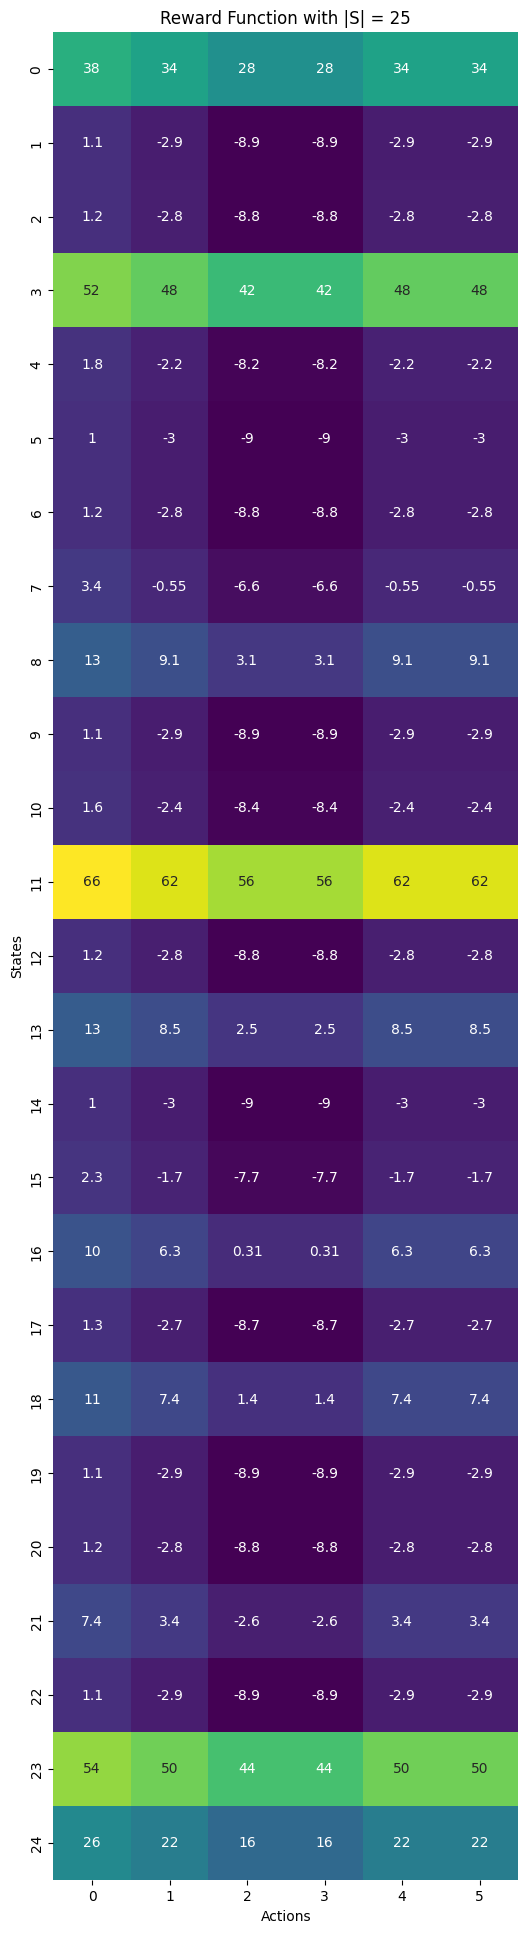

In [267]:
plot_reward_heatmap(reward_two)

In [230]:
def plot_rewards(rewards):
    """
    Plots a line plot of rewards across epochs using Seaborn.

    Args:
    rewards (np.array): A one-dimensional numpy array of total rewards per epoch.
    """
    # Convert array data into a DataFrame for Seaborn
    data = pd.DataFrame({
        'Epochs': np.arange(len(rewards)),
        'Total Rewards': rewards
    })

    # Creating the line plot using Seaborn
    sns.lineplot(x='Epochs', y='Total Rewards', data=data)

    # Optional: Set the labels and title using Matplotlib functions
    plt.xlabel('episode')              # Label for x-axis
    plt.ylabel('total reward')       # Label for y-axis
    plt.title('') # Title of the plot

    plt.show()   

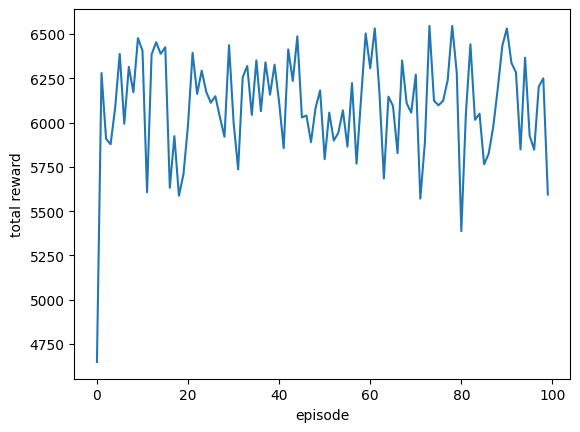

In [231]:
plot_rewards(total_rewards)

In [4]:
patients_df = read_csv_to_dataframe("data/patients.csv")
inputevents_df = read_csv_to_dataframe("data/inputevents.csv")
vitalsign_df = read_csv_to_dataframe("data/vitalsign.csv")

In [7]:
data_pv = pd.merge(patients_df, vitalsign_df, on='subject_id', how='inner')

# fill in missing values 
fill_NANS(data_pv)

# map rhythms  
unique_rhythms = data_pv['rhythm'].unique()
n_rhythms = len(unique_rhythms)
rhythms_mapping = {k:v for k,v in zip(unique_rhythms, range(n_rhythms))}

features = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp", "rhythm"]

M = construct_M(data_pv, features, rhythms_mapping) 

In [8]:
state_model = discretize_S(M, n_clusters=int(states))

NameError: name 'states' is not defined

In [ ]:
def calculate_cluster_medians(data, cluster_labels):
    """
    Calculate the average of each feature in each cluster.

    :param data: N x d array of data points (N data points, d features)
    :param cluster_labels: Array of length N with the cluster label for each data point
    :return: K x d array of cluster averages (K clusters, d features)
    """
    unique_clusters = np.unique(cluster_labels)
    num_features = data.shape[1]
    cluster_medians = np.zeros((len(unique_clusters), num_features))

    for i, cluster in enumerate(unique_clusters):
        cluster_data = data[cluster_labels == cluster]
        cluster_medians[i] = np.median(cluster_data, axis=0)

    return cluster_medians

In [ ]:
def calculate_cluster_averages(data, cluster_labels):
    """
    Calculate the average of each feature in each cluster.

    :param data: N x d array of data points (N data points, d features)
    :param cluster_labels: Array of length N with the cluster label for each data point
    :return: K x d array of cluster averages (K clusters, d features)
    """
    unique_clusters = np.unique(cluster_labels)
    num_features = data.shape[1]
    cluster_averages = np.zeros((len(unique_clusters), num_features))

    for i, cluster in enumerate(unique_clusters):
        cluster_data = data[cluster_labels == cluster]
        cluster_averages[i] = np.mean(cluster_data, axis=0)

    return cluster_averages

In [ ]:
med = calculate_cluster_medians(M, state_model.labels_)

In [ ]:
avg = calculate_cluster_averages(M, state_model.labels_)

In [ ]:
def create_dataframe_from_matrix(matrix, feature_labels):
    """
    Create a DataFrame from a given matrix and feature labels.

    :param matrix: An N x d numpy array or list of lists, where N is the number of data points and d is the number of features.
    :param feature_labels: A list of labels for the d features.
    :return: A Pandas DataFrame with the given data and feature labels.
    """
    if len(feature_labels) != matrix.shape[1]:
        raise ValueError("The number of feature labels must match the number of columns in the matrix.")

    return pd.DataFrame(matrix, columns=feature_labels)

In [ ]:
feature_labels =  ["anchor_age", "temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]

In [ ]:
df = create_dataframe_from_matrix(med, feature_labels)

In [ ]:
b = create_dataframe_from_matrix(med, feature_labels)

In [ ]:
b

,anchor_age,temperature,heartrate,resprate,o2sat,sbp,dbp
0,98.1,78.0,17.0,98.0,124.0,72.0,36.0
1,98.1,79.0,18.0,98.0,126.0,72.0,545.0
2,98.1,80.0,18.0,99.0,127.0,72.0,831.0
3,98.1,90.0,18.0,98.0,152.0,89.0,4.0
4,98.1,78.0,18.0,98.0,125.0,72.0,270.0
5,98.0,66.0,16.0,98.0,105.0,57.0,4.0
6,98.3,114.0,18.0,98.0,112.0,68.0,4.0
7,97.9,85.0,18.0,9712.0,140.0,74.0,7.0
8,98.0,68.0,17.0,98.0,142.0,64.0,4.0
9,98.1,78.0,18.0,98.0,127.0,72.0,110.0


In [ ]:
def plot_normalized(reward): 
    five_best = np.argsort(reward)[-5:]

    # Reverse the order to get the highest values first
    five_best = five_best[::-1]

    five_worst = np.argsort(reward)[:5][::-1]

    print(five_best)
    print(five_worst)
    
    z =  np.hstack((five_best, five_worst))

    n = len(feature_labels)
    m = 20

    M = np.zeros((n, m))

    for feature in range(n): 
        for index, state in enumerate(z): 
            M[feature][index] = b.iloc[state][feature_labels[feature]]

    n, m = M.shape 

    m_transpose = M.T

    for i in range(n): 
        for j in range(m): 
            M[i][j] = M[i][j] / (max(m_transpose[j]) - min(m_transpose[j]))

# Create a 2D grid of random values (replace with your data)

    # Create the heatmap
    plt.imshow(M, cmap='viridis')
    plt.colorbar(label='Relative (normalized) value')

    # Set custom y-axis labels
    plt.yticks(np.arange(len(feature_labels)), feature_labels)

    plt.xticks(np.arange(10), z)

    # Add labels and a title
    plt.xlabel('Clusters')

    plt.title('Critical Features')

    plt.figure(figsize=(16, 12))


    # Show the plot
    plt.show()
    

In [ ]:
def plot_critical_features(reward_functions, titles=[]):
    """
    Plots multiple 5x5 heatmaps using seaborn given a list of 1D numpy arrays, each of length 25.

    Parameters:
    reward_functions (list of numpy arrays): A list of 1D numpy arrays, each of length 25 representing reward functions.
    """
    n = len(reward_functions)
    if n == 0:
        raise ValueError("The list of reward functions is empty.")


    # Set up the plot grid
    fig, axes = plt.subplots(2,2, figsize=(24, 24))

    print(axes)

    for x, rf in enumerate(reward_functions):
        five_best = np.argsort(rf)[-5:][::-1]

        five_worst = np.argsort(rf)[:5][::-1]

        print(five_best)
        print(five_worst)
        
        z =  np.hstack((five_best, five_worst))

        n = len(feature_labels)
        m = 10

        M = np.zeros((n, m))

        for feature in range(n): 
            for index, state in enumerate(z): 
                M[feature][index] = b.iloc[state][feature_labels[feature]]

        n, m = M.shape 

        m_transpose = M.T

        for i in range(n): 
            for j in range(m): 
                M[i][j] = M[i][j] / (max(m_transpose[j]) - min(m_transpose[j]))

         # Plot using seaborn
        row = x // 2
        col = x % 2 
        if n > 1:
            ax = axes[row][col]
        else:
            ax = axes

        sns.heatmap(M, annot=True, cmap="viridis", cbar=False, ax=ax)
        ax.set_xticklabels(z)
        ax.set_yticklabels(feature_labels)
        ax.set_xlabel("States")
        ax.set_ylabel("Features")
        ax.set_title(titles[x])

    # plt.title("Critical Features")
    plt.tight_layout()
    plt.show()


[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]
[11 23  3  0 24]
[22 19  9 14  5]


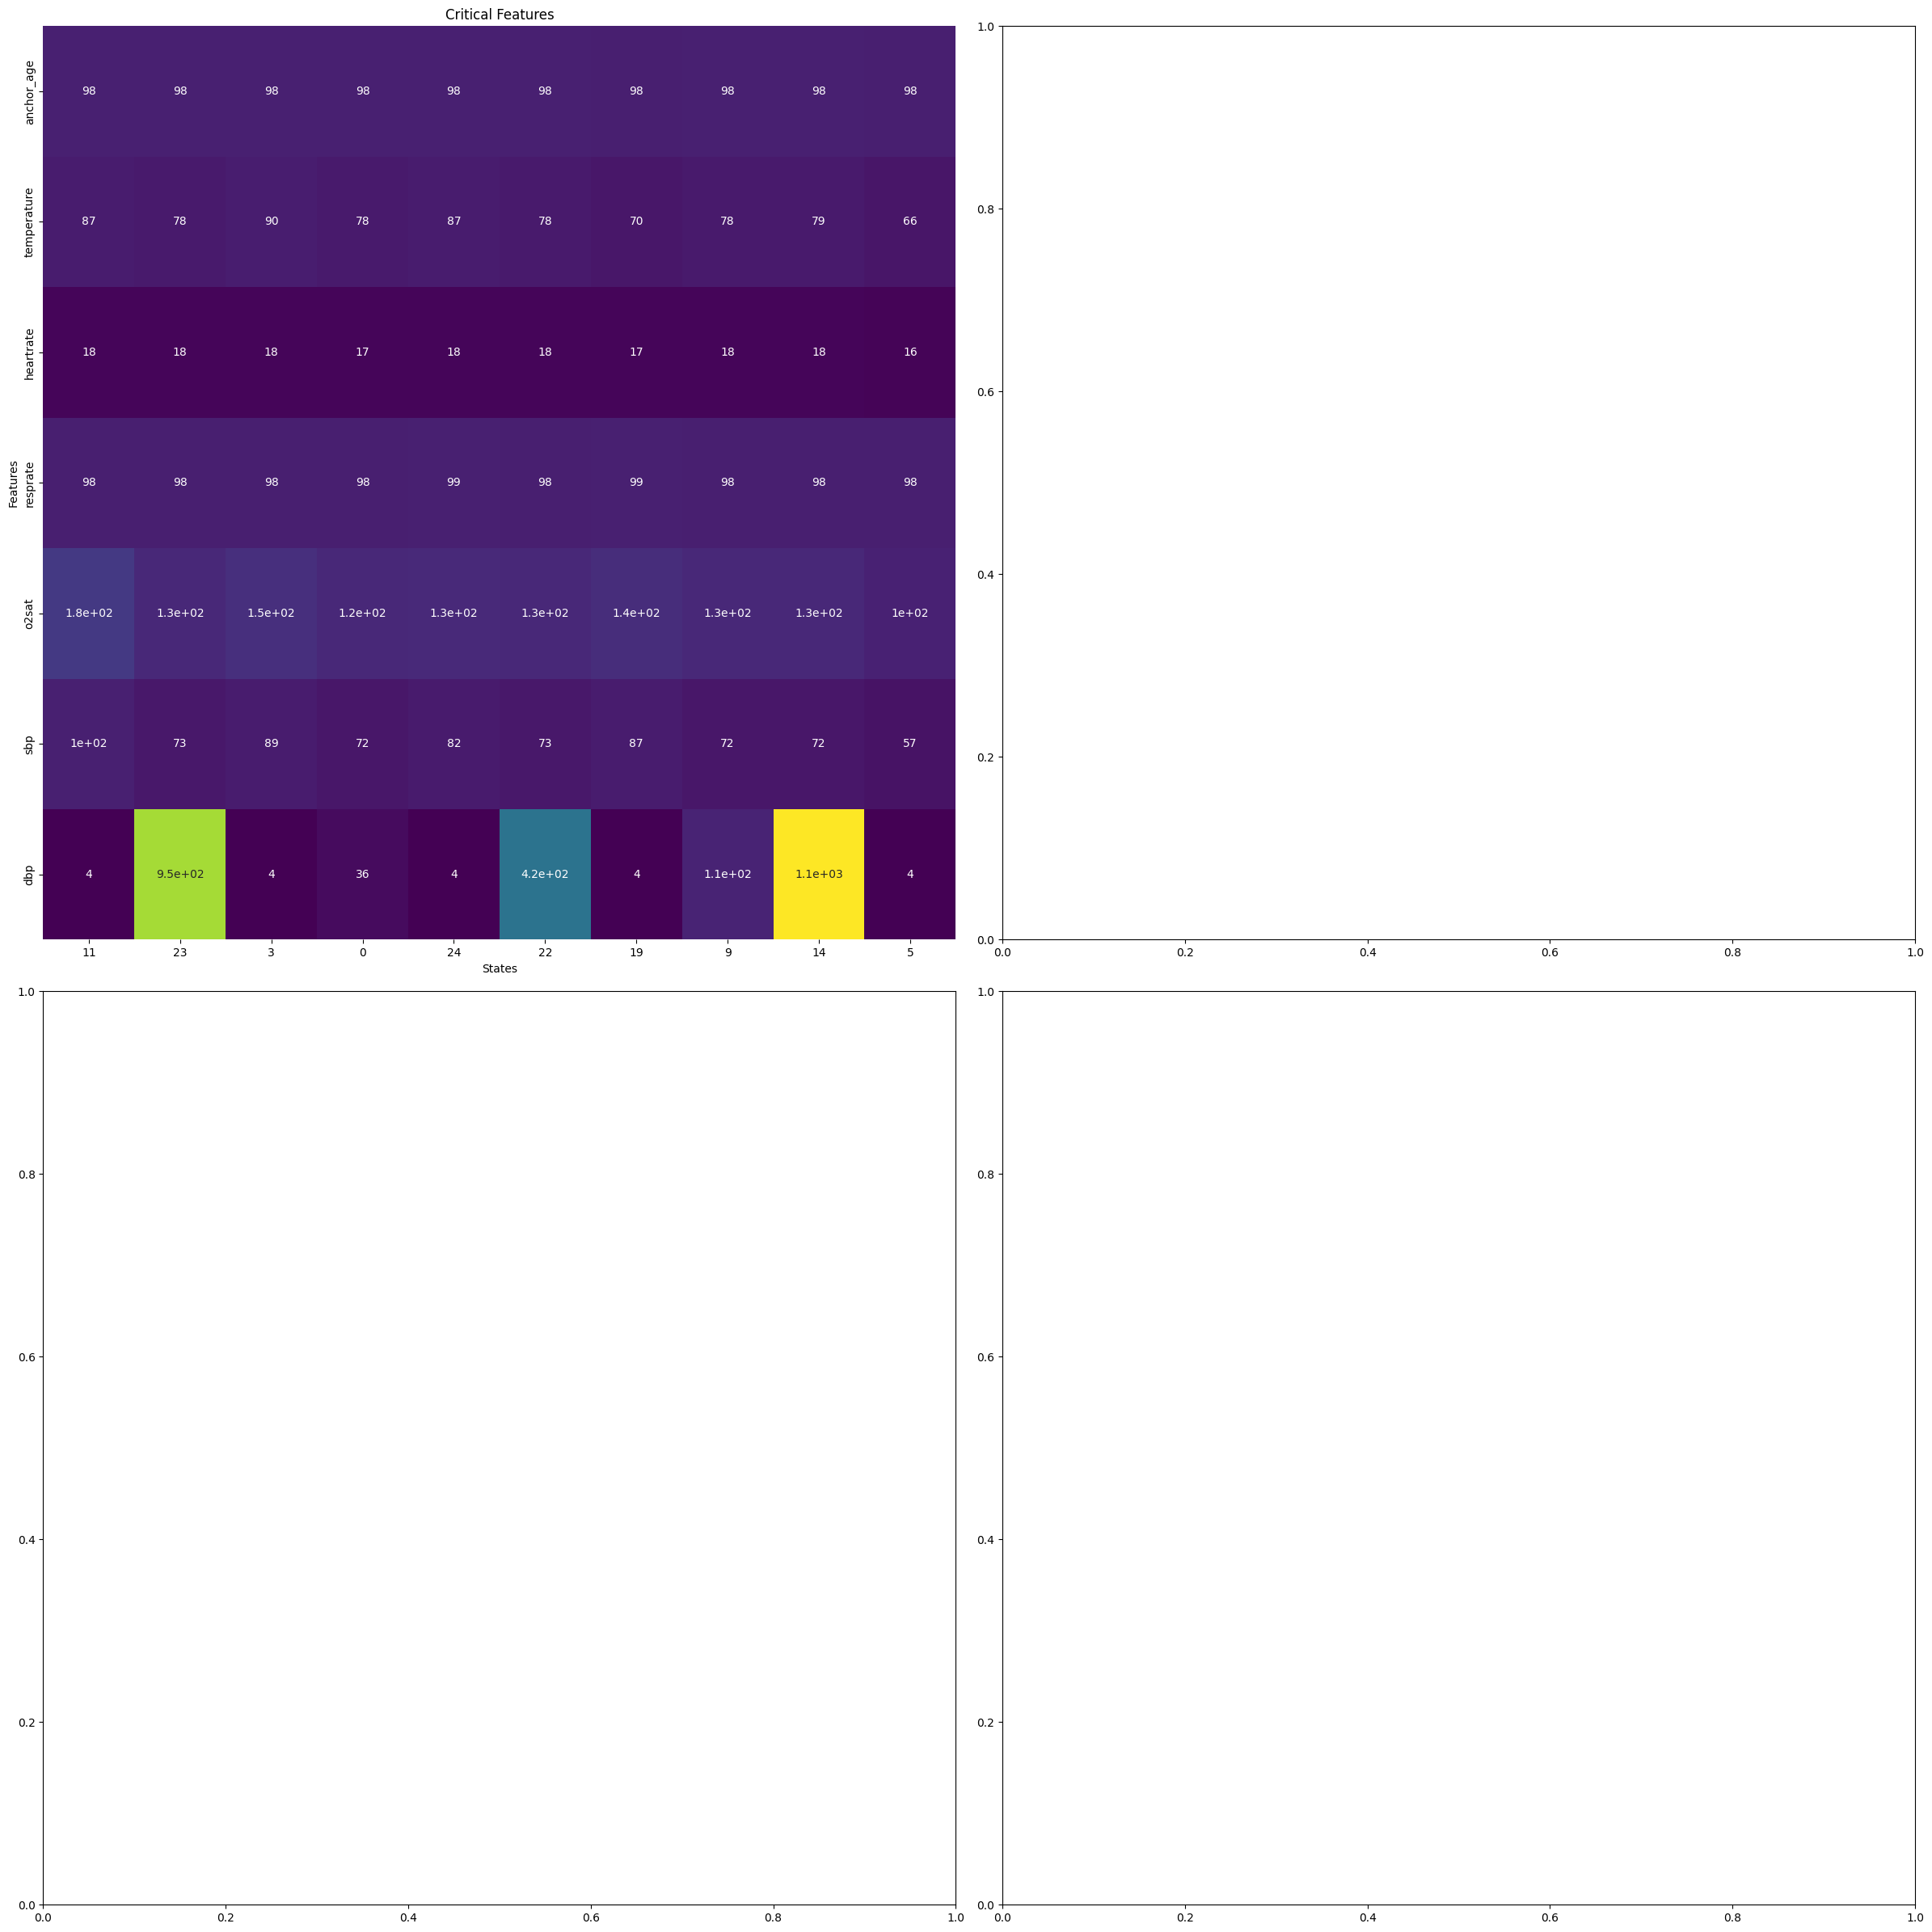

In [ ]:

plot_critical_features([reward.T[0]], titles=["Critical Features"])    